In [ ]:
# Install required packages
!pip install fastf1 pandas numpy xgboost scikit-learn matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.1 MB/s eta 0:00:00


In [ ]:
# Import libraries
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb
import os
import time

In [ ]:
# Configure data cache
cache_path = '/content/f1_cache'
os.makedirs(cache_path, exist_ok=True)
fastf1.Cache.enable_cache(cache_path)

In [ ]:
# Track settings
TRACKS = {
    'Melbourne': [2022, 2023],
    'Bahrain': [2022, 2023],
    'Silverstone': [2022, 2023],
    'Monza': [2022, 2023],
    'Suzuka': [2022, 2023]
}

In [ ]:
# Cell 5: Load and prepare data
def get_f1_data():
    """Get historical F1 lap data"""
    data = []
    feature_cols = ['LapNumber', 'Tyre', 'AirTemp', 'TrackTemp',
                   'Humidity', 'TyreAge', 'Driver', 'Track']

    for track, years in TRACKS.items():
        for year in years:
            try:
                session = fastf1.get_session(year, track, 'R')
                session.load()

                weather = session.weather_data
                temp = weather['AirTemp'].mean()
                track_temp = weather['TrackTemp'].mean()
                humidity = weather['Humidity'].mean()

                for driver in session.drivers:
                    laps = session.laps.pick_driver(driver)
                    if laps.empty: continue

                    laps = laps.copy()
                    laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()
                    laps['Tyre'] = laps['Compound'].map({"SOFT":0, "MEDIUM":1, "HARD":2})
                    laps['Driver'] = pd.factorize(laps['Driver'])[0]
                    laps['Track'] = track
                    laps['AirTemp'] = temp
                    laps['TrackTemp'] = track_temp
                    laps['Humidity'] = humidity
                    laps['TyreAge'] = laps['LapNumber']

                    data.append(laps[feature_cols + ['LapTimeSeconds']])

                print(f"Loaded {track} {year}")

            except Exception as e:
                print(f"Skipped {track} {year}: {str(e)[:50]}")
                continue

    df = pd.concat(data, ignore_index=True)
    df['Track'] = pd.factorize(df['Track'])[0]
    return df.dropna()

# Load dataset
df = get_f1_data()
print(f"\nLoaded {len(df)} laps of data")

In [ ]:
# Train model
# Split data
X = df.drop('LapTimeSeconds', axis=1)
y = df['LapTimeSeconds']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train model
model = xgb.XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.1)
model.fit(X_train, y_train)

# Calculate performance
start = time.time()
preds = model.predict(X_test)
speed = (time.time()-start)/len(X_test)*1000
r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f"Model trained - R²: {r2:.2f}, MAE: {mae:.2f}s")
print(f"Prediction speed: {speed:.2f}ms per lap")

Model trained - R²: 0.80, MAE: 2.54s
Prediction speed: 0.01ms per lap


In [ ]:
# Simulation parameters
TRACK = 'Melbourne'       # Options: Melbourne, Bahrain, Silverstone, Monza, Suzuka
AIR_TEMP = 25             # Degrees Celsius
TRACK_TEMP = 40           # Degrees Celsius
HUMIDITY = 45             # Percentage
WEATHER = 'Dry'           # Options: Dry or Wet

In [ ]:
# Strategy functions
def make_strategy(strat_type):
    """Generate strategy dataframe"""
    base = {
        'LapNumber': list(range(1,56)),
        'Tyre': [0]*20 + [1]*35,
        'AirTemp': AIR_TEMP,
        'TrackTemp': TRACK_TEMP,
        'Humidity': HUMIDITY,
        'TyreAge': list(range(1,56)),
        'Driver': 1,
        'Track': list(TRACKS.keys()).index(TRACK)
    }



    return pd.DataFrame(base)[['LapNumber', 'Tyre', 'AirTemp', 'TrackTemp', 'Humidity', 'TyreAge', 'Driver', 'Track']] # Specifying column order

def plot_strat(data, times, title):
    """Visualize strategy with tyre info"""
    colors = {0:'#FF3333', 1:'#FFD700', 2:'#FFFFFF'}

    plt.figure(figsize=(12,5))
    plt.plot(data['LapNumber'], times, color='#00D2BE')

    # Add tyre zones
    current = None
    start = 1
    for lap, tyre in enumerate(data['Tyre'], 1):
        if tyre != current:
            if current is not None:
                plt.axvspan(start-0.5, lap-0.5, color=colors[current], alpha=0.2)
            current = tyre
            start = lap
    plt.axvspan(start-0.5, 55.5, color=colors[current], alpha=0.2)

    # Mark pit stops
    pit_laps = []
    for i in range(1, len(data)):
        if data['Tyre'].iloc[i] != data['Tyre'].iloc[i-1]:
            pit_laps.append(i+1)

    for lap in pit_laps:
        plt.axvline(lap-0.5, color='#FF8700', linestyle='--')

    plt.title(title)
    plt.xlabel("Lap Number")
    plt.ylabel("Lap Time (s)")
    plt.grid(alpha=0.2)
    plt.show()

1-Stop Total: 85.55 mins
2-Stop Total: 85.97 mins
Time Difference: 25.00 seconds


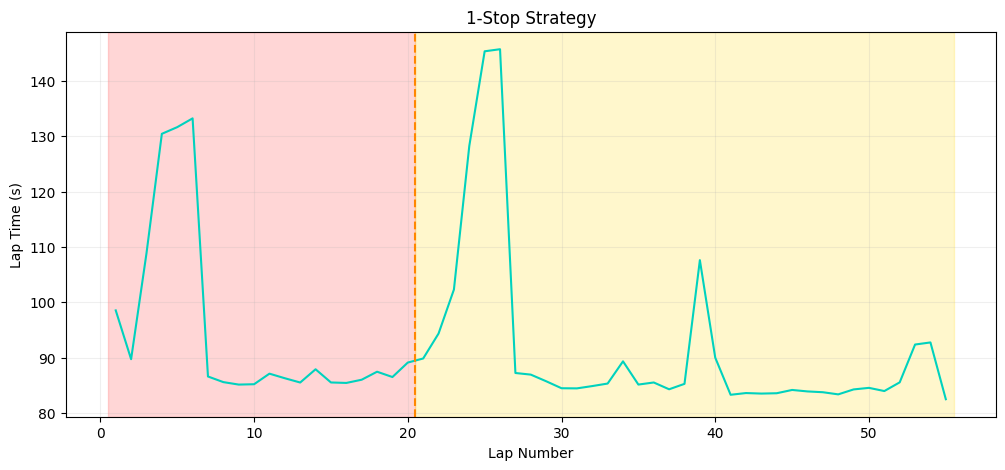

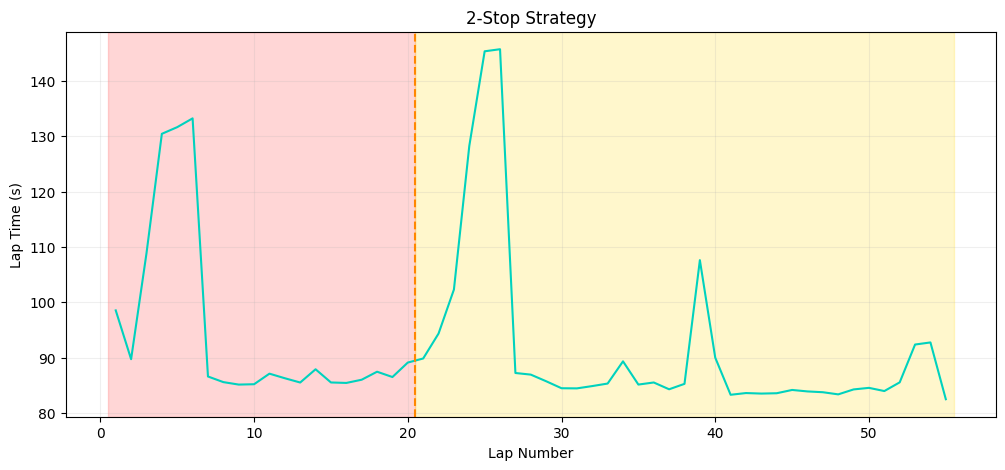

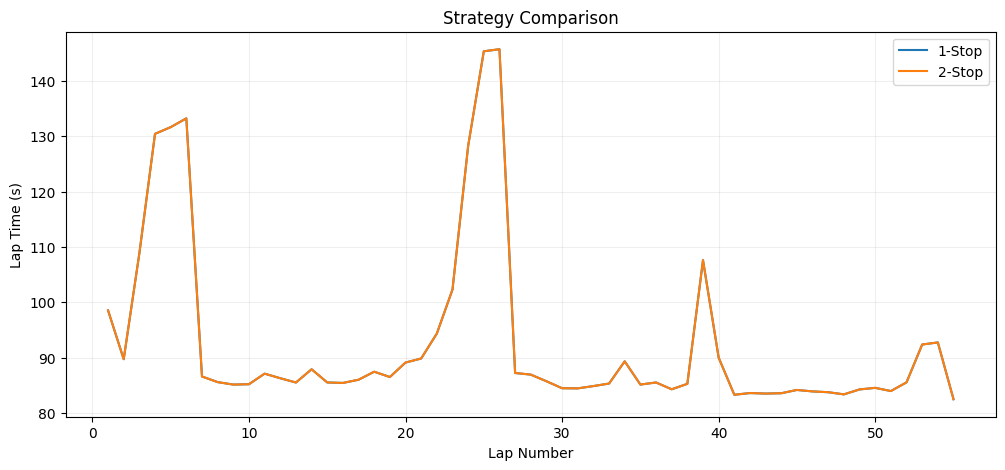

In [ ]:
# Run simulation
# Generate strategies
strat1 = make_strategy("1-stop")
strat2 = make_strategy("2-stop")

# Get predictions
times1 = model.predict(strat1)
times2 = model.predict(strat2)

# Apply weather penalty
if WEATHER == 'Wet':
    times1 += np.random.uniform(2, 5, 55)
    times2 += np.random.uniform(2, 5, 55)

# Add pit stop times
total1 = times1.sum() + 25*1
total2 = times2.sum() + 25*2

# Show results
print(f"1-Stop Total: {total1/60:.2f} mins")
print(f"2-Stop Total: {total2/60:.2f} mins")
print(f"Time Difference: {abs(total1-total2):.2f} seconds")

# Plot strategies
plot_strat(strat1, times1, "1-Stop Strategy")
plot_strat(strat2, times2, "2-Stop Strategy")

# Comparison plot
plt.figure(figsize=(12,5))
plt.plot(strat1['LapNumber'], times1, label='1-Stop')
plt.plot(strat2['LapNumber'], times2, label='2-Stop')
plt.title("Strategy Comparison")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (s)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()